In [1]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [2]:
# import data
france = pd.read_csv('C:/Users/allis/OneDrive/Documents/ARLIS/France_USABidenTrump_Mar1-Aug1.csv')

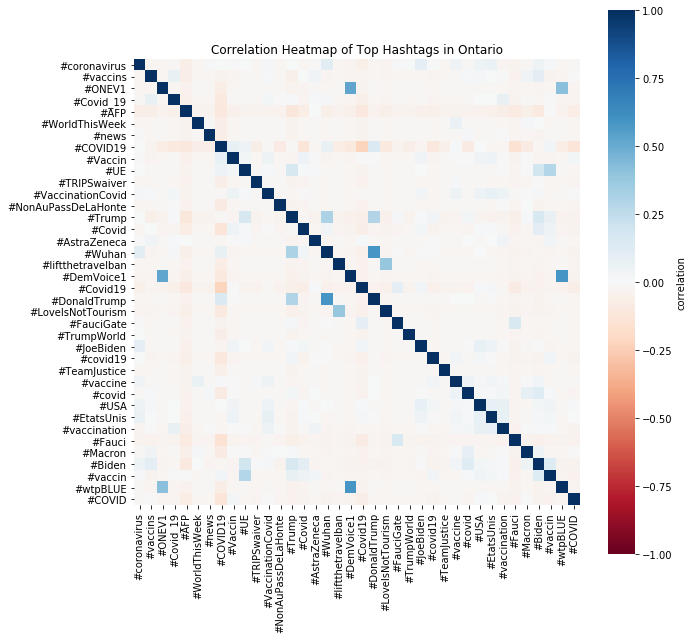

In [4]:
# define function to return hashtags
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

#create new column containing hashtags
france['hashtags'] = france.body.apply(find_hashtags)

# create separate data frame containing hashtags
hashtags_list_df = france.loc[ 
                       france.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']] 

# flatten hastags (one hashtag per row)
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

# count hashtags
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

# find popular hashtags appearing more than 10 times and create python set
min_appearance = 50
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

# make matrix of hashtags
for hashtag in popular_hashtags_set:
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
seaborn.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'}).set(title='Correlation Heatmap of Top Hashtags in Ontario')
plt.show()

In [5]:
# functions for text cleaning

def remove_links(tweet):
    '''Takes a string and removes links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

def remove_emoji(string):
    ''' Takes a string and removes all emojis using unicode'''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def fix_quotes(tweet):
    ''' Takes a string and replaces curly quotation marks'''
    tweet = tweet.replace(u'\u201c', '\'') # replacing curly quotes
    tweet = tweet.replace('”', '\'') 
    tweet = tweet.replace('’', '\'')
    return tweet

<>:12: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-01fa1c0267c7>:12: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet


In [14]:
# clean English tweets
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# English master function
def clean_tweet(tweet, bigrams=False):
    '''Takes a string and returns uniform stemmed words and bigrams'''
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_emoji(tweet)
    tweet = tweet.lower() # lower case
    tweet = fix_quotes(tweet)
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

<>:15: DeprecationWarning: invalid escape sequence \s
<>:15: DeprecationWarning: invalid escape sequence \s
<>:15: DeprecationWarning: invalid escape sequence \s
<ipython-input-14-a41ea51776ae>:15: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet) #remove double spacing


In [15]:
# clean French tweets
my_french_stopwords = nltk.corpus.stopwords.words('french')

# French master function
def clean_tweet_french(tweet, bigrams=False):
    '''Takes a string and returns uniform stemmed words and bigrams'''
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_emoji(tweet)
    tweet = tweet.lower() # lower case
    tweet = fix_quotes(tweet)
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_french_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

<>:13: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-15-d72c246d9aec>:13: DeprecationWarning: invalid escape sequence \s
  tweet = re.sub('\s+', ' ', tweet) #remove double spacing


In [16]:
france_english = france.loc[france['language'] == 'English'] # get English and French separated
france_french = france.loc[france['language'] == 'French']

In [17]:
france_english['clean_text'] = france_english.body.apply(clean_tweet)

france_french['clean_text'] = france_french.body.apply(clean_tweet_french)

C:\Users\allis\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\allis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Generate tokenized words from texts

In [19]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

#generate english tokenized words
eng_data_words = gen_words(france_english.clean_text)
print (eng_data_words[0:3])

#generate english tokenized words
fr_data_words = gen_words(france_french.clean_text)
print (fr_data_words[0:3])

[['contrari', 'tx', 'fl', 'governor', 'pass', 'execut', 'order', 'mask', 'mandat', 'make', 'lot', 'sens', 'biden', 'ran', 'get', 'coronavirus', 'control', 'republicans', 'vow', 'obstruct', 'success', 'ye', 'obstruct', 'success', 'expens', 'american', 'live'], ['mani', 'msm', 'hardli', 'ever', 'spin', 'news', 'posit', 'biden', 'administr', 'glorifi', 'follow', 'breathlessli', 'tfg', 'crimin', 'sociopath', 'intent', 'allow', 'half', 'million', 'die', 'hillaryclinton', 'would', 'presid', 'overse', 'pandem'], ['consid', 'kkkevinmccarthy', 'seem', 'typic', 'russian', 'republikkklan', 'covidiot', 'cant', 'help', 'think', 'didnt', 'come', 'joke', 'seem', 'like', 'one', 'trump', 'copi', 'puppet', 'master', 'trump']]
[['septembr', 'trump', 'alertait', 'dernier', 'rempart', 'contr', 'socialism', 'mondialise', 'va', 'profit', 'nouveau', 'coronaviru', 'reduir', 'drastiqu', 'liberte', 'divis', 'peupl', 'reglement', 'vie', 'prive', 'masquer', 'enfant'], ['maroc', 'pay', 'plu', 'vaccine', 'mond', 'va

Generate tokenized words as column in existing data frame to get date metadata

In [47]:
# generate english tokenized words as a column in original dataframe
# English
france_english['eng_data_word'] = gen_words(france_english.clean_text)
france_english.head()

# French
france_french['fr_data_word'] = gen_words(france_french.clean_text)
france_french.head()

C:\Users\allis\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\allis\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,profile,date,body,title,author_username,language,sentiment,potential_impressions,url,timestamp,...,country,state,word_count,followers_count,automation_score,author_bio,issues,hashtags,clean_text,fr_data_word
0,COVID-19,2021-08-01T15:03:53Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@volkoffvitch,French,Positive,831664,https://twitter.com/VOLKOFFVITCH/status/1421849171485773826,1627830233000,...,France,Île-de-France,39,698,56,SENIOR RETRAITE INTERETS PRINCIPAUX : CULTURES PHILOSOPHIES THEOLOGIES VOILE POLITIQUES............,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,..."
3,COVID-19,2021-08-01T14:53:04Z,RT @rifain_nouvelle: 🔥 Le Maroc l’un des pays les plus vaccinés au monde .. les variants COVID-1...,RT @rifain_nouvelle: 🔥 Le Maroc l’un des pays les plus vaccinés au monde .. les variants COVID-1...,@thewhite_tigger,French,Neutral,394612,https://twitter.com/thewhite_tigger/status/1421846447721431047,1627829584000,...,France,Île-de-France,48,402,38,"Miltaro-droito-trumpo-poutino-animo\nHier est bien mieux que demain, alors pourquoi attendre",Vietnam,[],maroc pay plu vacciné mond variant covid explos hôpitaux grand vill casa rabat saturé personn ...,"[maroc, pay, plu, vaccine, mond, variant, covid, explos, hopitaux, grand, vill, casa, rabat, sat..."
4,COVID-19,2021-08-01T14:50:06Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@aboudiberri,French,Positive,831664,https://twitter.com/AboudiBerri/status/1421845702553083904,1627829406000,...,France,Île-de-France,39,166,44,...!,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,..."
5,COVID-19,2021-08-01T14:46:59Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@thewhite_tigger,French,Positive,831664,https://twitter.com/thewhite_tigger/status/1421844918973128708,1627829219000,...,France,Île-de-France,39,402,38,"Miltaro-droito-trumpo-poutino-animo\nHier est bien mieux que demain, alors pourquoi attendre",Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,..."
6,COVID-19,2021-08-01T14:44:49Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@jmhugonie,French,Positive,831664,https://twitter.com/JmHugonie/status/1421844372170190855,1627829089000,...,France,Île-de-France,39,5225,49,🇫🇷Nationaliste - souverainiste anti-conformiste - ancien membre du Club de l'Horloge - Ancien me...,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,..."


Create bigrams and trigrams from tokenized words using gensim

In [48]:
# English bigrams and trigrams
eng_bigram_phrases = gensim.models.Phrases(eng_data_words, min_count=5, threshold=25) # look for bigrams
eng_trigram_phrases = gensim.models.Phrases(eng_bigram_phrases[eng_data_words], threshold=25) #use bigrams to look for trigrams

eng_bigram = gensim.models.phrases.Phraser(eng_bigram_phrases) # create bigram and trigram phrases
eng_trigram = gensim.models.phrases.Phraser(eng_trigram_phrases)

def make_bigrams(texts):
    return([eng_bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([eng_trigram[eng_bigram[doc]] for doc in texts])

eng_data_bigrams = make_bigrams(eng_data_words) # run function to add bigrams and trigrams
eng_data_bigrams_trigrams = make_trigrams(eng_data_bigrams)
france_english['eng_data_bigrams_trigrams'] = make_trigrams(eng_data_bigrams) # create bigrams/trigrams as column
france_english.head()

# French bigrams and trigrams
fr_bigram_phrases = gensim.models.Phrases(fr_data_words, min_count=5, threshold=25) # look for bigrams
fr_trigram_phrases = gensim.models.Phrases(fr_bigram_phrases[fr_data_words], threshold=25) #use bigrams to look for trigrams

fr_bigram = gensim.models.phrases.Phraser(fr_bigram_phrases) # create bigram and trigram phrases
fr_trigram = gensim.models.phrases.Phraser(fr_trigram_phrases)

def make_bigrams(texts):
    return([fr_bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([fr_trigram[fr_bigram[doc]] for doc in texts])

fr_data_bigrams = make_bigrams(fr_data_words) # run function to add bigrams and trigrams
fr_data_bigrams_trigrams = make_trigrams(fr_data_bigrams)
france_french['fr_data_bigrams_trigrams'] = make_trigrams(fr_data_bigrams) # create bigrams/trigrams as column
france_french.head()

C:\Users\allis\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\allis\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,profile,date,body,title,author_username,language,sentiment,potential_impressions,url,timestamp,...,state,word_count,followers_count,automation_score,author_bio,issues,hashtags,clean_text,fr_data_word,fr_data_bigrams_trigrams
0,COVID-19,2021-08-01T15:03:53Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@volkoffvitch,French,Positive,831664,https://twitter.com/VOLKOFFVITCH/status/1421849171485773826,1627830233000,...,Île-de-France,39,698,56,SENIOR RETRAITE INTERETS PRINCIPAUX : CULTURES PHILOSOPHIES THEOLOGIES VOILE POLITIQUES............,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,...","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
3,COVID-19,2021-08-01T14:53:04Z,RT @rifain_nouvelle: 🔥 Le Maroc l’un des pays les plus vaccinés au monde .. les variants COVID-1...,RT @rifain_nouvelle: 🔥 Le Maroc l’un des pays les plus vaccinés au monde .. les variants COVID-1...,@thewhite_tigger,French,Neutral,394612,https://twitter.com/thewhite_tigger/status/1421846447721431047,1627829584000,...,Île-de-France,48,402,38,"Miltaro-droito-trumpo-poutino-animo\nHier est bien mieux que demain, alors pourquoi attendre",Vietnam,[],maroc pay plu vacciné mond variant covid explos hôpitaux grand vill casa rabat saturé personn ...,"[maroc, pay, plu, vaccine, mond, variant, covid, explos, hopitaux, grand, vill, casa, rabat, sat...","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe..."
4,COVID-19,2021-08-01T14:50:06Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@aboudiberri,French,Positive,831664,https://twitter.com/AboudiBerri/status/1421845702553083904,1627829406000,...,Île-de-France,39,166,44,...!,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,...","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
5,COVID-19,2021-08-01T14:46:59Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@thewhite_tigger,French,Positive,831664,https://twitter.com/thewhite_tigger/status/1421844918973128708,1627829219000,...,Île-de-France,39,402,38,"Miltaro-droito-trumpo-poutino-animo\nHier est bien mieux que demain, alors pourquoi attendre",Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,...","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
6,COVID-19,2021-08-01T14:44:49Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",@jmhugonie,French,Positive,831664,https://twitter.com/JmHugonie/status/1421844372170190855,1627829089000,...,Île-de-France,39,5225,49,🇫🇷Nationaliste - souverainiste anti-conformiste - ancien membre du Club de l'Horloge - Ancien me...,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,...","[septembr, trump, alertait_d

In [39]:
# concatenate English and French for combined model
all_data_bigrams_trigrams = fr_data_bigrams_trigrams + eng_data_bigrams_trigrams

28805

In [40]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# English
# Create a dictionary representation of the documents
eng_id2word = Dictionary(eng_data_bigrams_trigrams)

# Filter out words that occur less than 20 documents, or more than 95% of the documents
eng_id2word.filter_extremes(no_below=20, no_above=0.9)

# Create Corpus: Term Document Frequency
eng_corpus = [eng_id2word.doc2bow(text) for text in eng_data_bigrams_trigrams]

print (eng_corpus[0:3][0:20])

eng_word = eng_id2word[[0][:1][0]]
print (eng_word)

# French
# Create a dictionary representation of the documents
fr_id2word = Dictionary(fr_data_bigrams_trigrams)

# Filter out words that occur less than 20 documents, or more than 95% of the documents
fr_id2word.filter_extremes(no_below=20, no_above=0.9)

# Create Corpus: Term Document Frequency
fr_corpus = [fr_id2word.doc2bow(text) for text in fr_data_bigrams_trigrams]

print (fr_corpus[0:3][0:20])

fr_word = fr_id2word[[0][:1][0]]
print (fr_word)

# Combined
# Create a dictionary representation of the documents
all_id2word = Dictionary(all_data_bigrams_trigrams)

# Filter out words that occur less than 20 documents, or more than 95% of the documents
all_id2word.filter_extremes(no_below=20, no_above=0.9)

# Create Corpus: Term Document Frequency
all_corpus = [all_id2word.doc2bow(text) for text in all_data_bigrams_trigrams]

print (all_corpus[0:3][0:20])

all_word = all_id2word[[0][:1][0]]
print (all_word)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1)], [(1, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 2)]]
american
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1)], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]
alertait_dernier_rempart_contr
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)], [(8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 2), (20, 1)], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]
alertait_dernier_rempart_contr


Run model and create visualization

In [23]:
# English LDA model
eng_lda_model = gensim.models.ldamodel.LdaModel(corpus=eng_corpus,
                                            id2word=eng_id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=500,
                                            passes=10,
                                            alpha="auto")

In [24]:
# French LDA model
fr_lda_model = gensim.models.ldamodel.LdaModel(corpus=fr_corpus,
                                            id2word=fr_id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=500,
                                            passes=10,
                                            alpha="auto")

In [41]:
# Combined LDA model
all_lda_model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,
                                            id2word=all_id2word,
                                            num_topics=10,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=500,
                                            passes=10,
                                            alpha="auto")

In [25]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(eng_lda_model, eng_corpus, eng_id2word, mds="mmds", R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.359130  0.262428       1        1  19.672761
0      0.121381  0.407480       2        1  14.616321
5     -0.140954 -0.060268       3        1  13.779948
3     -0.172976  0.429429       4        1  12.775951
6      0.175051 -0.451419       5        1  11.210280
2     -0.378641  0.208971       6        1   6.030797
8     -0.193780 -0.433639       7        1   5.848896
4     -0.472278 -0.134598       8        1   5.665762
9      0.220103 -0.152889       9        1   5.295521
1      0.482964 -0.075493      10        1   5.103763, topic_info=        Term         Freq        Total Category  logprob  loglift
1      biden  8420.000000  8420.000000  Default  10.0000  10.0000
41     trump  6148.000000  6148.000000  Default   9.0000   9.0000
65    vaccin  6771.000000  6771.000000  Default   8.0000   8.0000
44     covid  7286.000000  7286.000000  Default   7.0000   7.0000
30    presid  3343.000000  3343.000000  Default   6.0000   6.0000
...      ...          ...          ...      ...      ...      ...
585     well   192.482678   193.381482  Topic10  -3.8745   2.9705
454     last   187.668867   188.567714  Topic10  -3.8998   2.9704
1222  promis   176.849103   177.747960  Topic10  -3.9592   2.9701
484   econom   173.572622   174.471472  Topic10  -3.9779   2.9700
440   scienc   165.293627   166.192433  Topic10  -4.0268   2.9698

[125 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
163       6  0.998052      admin
17        1  0.998817  administr
630       9  0.995316      adult
1183      6  0.995951        aid
528       5  0.997653    america
...     ...       ...        ...
416       2  0.006212       work
416       5  0.991889       work
141       8  0.996860      world
31        4  0.999458      would
275       4  0.998844       year

[140 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 6, 4, 7, 3, 9, 5, 10, 2])

In [26]:
fr_vis = gensimvis.prepare(fr_lda_model, fr_corpus, fr_id2word, mds="mmds", R=10)
fr_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.006216  0.060618       1        1  27.421304
4      0.054577 -0.410120       2        1  16.061712
8     -0.386204 -0.141462       3        1  10.254354
2     -0.227782  0.396245       4        1   8.927165
9      0.347987 -0.326283       5        1   8.413471
7      0.409514 -0.040940       6        1   7.977266
3      0.101835  0.452898       7        1   6.272085
0     -0.247841 -0.399840       8        1   5.878583
5     -0.441447  0.145765       9        1   4.911687
1      0.383144  0.263121      10        1   3.882372, topic_info=                 Term         Freq        Total Category  logprob  loglift
53              biden  4168.000000  4168.000000  Default  10.0000  10.0000
61             vaccin  7040.000000  7040.000000  Default   9.0000   9.0000
23               etat  6144.000000  6144.000000  Default   8.0000   8.0000
29                uni  5866.000000  5866.000000  Default   7.0000   7.0000
10              covid  7131.000000  7131.000000  Default   6.0000   6.0000
...               ...          ...          ...      ...      ...      ...
481          europeen   151.867450   152.740879  Topic10  -3.4132   3.2430
175        administre   145.400919   146.274465  Topic10  -3.4567   3.2427
563             avril   122.410260   123.283691  Topic10  -3.6288   3.2416
480         economiqu    97.394929    98.268370  Topic10  -3.8574   3.2398
1282  hain_si_parlion    91.097941    91.971445  Topic10  -3.9242   3.2392

[115 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
109       7  0.998425   administr
175      10  0.991287  administre
351       1  0.999164         afp
226       3  0.996270        alor
122       6  0.998948   americain
...     ...       ...         ...
61        3  0.001988      vaccin
61        4  0.000426      vaccin
19        6  0.999078     vaccine
225       9  0.994329        veut
87        4  0.999085         via

[112 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 9, 3, 10, 8, 4, 1, 6, 2])

In [42]:
all_vis = gensimvis.prepare(all_lda_model, all_corpus, all_id2word, mds="mmds", R=10)
all_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.018049  0.070251       1        1  32.875243
4      0.051410 -0.433335       2        1  19.234496
9     -0.393401 -0.145975       3        1  13.644199
0     -0.224606  0.392555       4        1   6.497461
1      0.329471 -0.310011       5        1   6.021250
5      0.426728 -0.039058       6        1   5.402874
6      0.099524  0.450546       7        1   5.375068
3     -0.246781 -0.392786       8        1   4.351763
2     -0.432316  0.148883       9        1   4.347910
7      0.371922  0.258929      10        1   2.249736, topic_info=                    Term          Freq         Total Category  logprob  \
57                 biden  14701.000000  14701.000000  Default  10.0000   
65                vaccin  12163.000000  12163.000000  Default   9.0000   
10                 covid  11305.000000  11305.000000  Default   8.0000   
7                  trump   9561.000000   9561.000000  Default   7.0000   
117             american   4252.000000   4252.000000  Default   6.0000   
...                  ...           ...           ...      ...      ...   
461                feder    304.597279    305.674358  Topic10  -3.1233   
129               demand    228.556131    229.633129  Topic10  -3.4105   
204              confirm    214.128247    215.205342  Topic10  -3.4757   
1398          leadership    206.636816    207.713858  Topic10  -3.5113   
2963  suppli_everi_adult    211.110707    212.243356  Topic10  -3.4899   

      loglift  
57    10.0000  
65     9.0000  
10     8.0000  
7      7.0000  
117    6.0000  
...       ...  
461    3.7908  
129    3.7897  
204    3.7893  
1398   3.7892  
2963   3.7890  

[113 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
115       6  0.994898         act
116       9  0.999520   administr
1227      9  0.998138       adult
681       6  0.998629         aid
522       5  0.999616     america
...     ...       ...         ...
1081      9  0.995110       video
353       8  0.999511        vote
2041      8  0.998013  white_hous
717       1  0.999192       would
1032      2  0.997971        year

[106 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 10, 1, 2, 6, 7, 4, 3, 8])

Get list of words from each topic

In [43]:
print('English Topic Model')
for idx, topic in eng_lda_model.show_topics(formatted=False, num_words= 15):
    print('Topic: {} \nWords: {}'.format(idx, ', '.join([w[0] for w in topic])))
print('French Topic Model')
for idx, topic in fr_lda_model.show_topics(formatted=False, num_words= 15):
    print('Topic: {} \nWords: {}'.format(idx, ', '.join([w[0] for w in topic])))
print('Combined Topic Model')
for idx, topic in all_lda_model.show_topics(formatted=False, num_words= 15):
    print('Topic: {} \nWords: {}'.format(idx, ', '.join([w[0] for w in topic])))

English Topic Model
Topic: 0 
Words: american, get, peopl, say, million, one, everi, want, coronaviru, like, covid, need, use, donald, respons
Topic: 1 
Words: approv, handl, school, made, oper_warp_speed, well, last, promis, econom, scienc, feel, billion, speed, clear, restrict
Topic: 2 
Words: bill, admin, report, open, texa, test, aid, public, week, send, effort, rememb, hope, claim, congress
Topic: 3 
Words: would, know, said, go, still, year, viru, let, take, end, think, come, may, kill, tri
Topic: 4 
Words: gop, got, thank, lie, money, news, world, put, check, lost, left, hit, leader, seem, top
Topic: 5 
Words: trump, covid, relief_bill, support, call, death, give, die, china, credit, sign, refus, polit, fail, melania
Topic: 6 
Words: pandem, plan, republican, relief, help, state, democrat, work, america, pass, make, nation, includ, job, sinc
Topic: 7 
Words: biden, vaccin, presid, us, covid, administr, joe, new, day, today, announc, countri, dose, via, first
Topic: 8 
Words: vot

Get topic probabilities

In [49]:
eng_l=[eng_lda_model.get_document_topics(item) for item in eng_corpus]
fr_l=[fr_lda_model.get_document_topics(item) for item in fr_corpus]
all_l=[all_lda_model.get_document_topics(item) for item in all_corpus]

Get dominant topic and percentage contribution for each document (tweet)

In [50]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# English
eng_df_topic_sents_keywords = format_topics_sentences(ldamodel=eng_lda_model, corpus=eng_corpus, texts=eng_data_bigrams_trigrams)
# Format
eng_df_dominant_topic = eng_df_topic_sents_keywords.reset_index()
eng_df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
eng_df_dominant_topic.head(10)

# French
fr_df_topic_sents_keywords = format_topics_sentences(ldamodel=fr_lda_model, corpus=fr_corpus, texts=fr_data_bigrams_trigrams)
# Format
fr_df_dominant_topic = fr_df_topic_sents_keywords.reset_index()
fr_df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
fr_df_dominant_topic.head(10)

# Combined
all_df_topic_sents_keywords = format_topics_sentences(ldamodel=all_lda_model, corpus=all_corpus, texts=all_data_bigrams_trigrams)
# Format
all_df_dominant_topic = all_df_topic_sents_keywords.reset_index()
all_df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
all_df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.2860,"peopl, get, us, say, republican, would, enough, one, relief, help","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
1,1,0.0,0.2685,"state, lie, nation, credit, tell, media, melania, chang, possibl, total","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe..."
2,2,8.0,0.2860,"peopl, get, us, say, republican, would, enough, one, relief, help","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
3,3,8.0,0.2860,"peopl, get, us, say, republican, would, enough, one, relief, help","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
4,4,8.0,0.2860,"peopl, get, us, say, republican, would, enough, one, relief, help","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
5,5,8.0,0.2860,"peopl, get, us, say, republican, would, enough, one, relief, help","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
6,6,0.0,0.2685,"state, lie, nation, credit, tell, media, melania, chang, possibl, total","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe..."
7,7,0.0,0.2685,"state, lie, nation, credit, tell, media, melania, chang, possibl, total","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe..."
8,8,0.0,0.2685,"state, lie, nation, credit, tell, media, melania, chang, possibl, total","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe..."
9,9,8.0,0.2860,"peopl, get, us, say, republican, would, enough, one, relief, help","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."


Get document which best represent each topic (highest percent contributing)

In [51]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

# English
eng_sent_topics_sorteddf_mallet = pd.DataFrame()
eng_sent_topics_outdf_grpd = eng_df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in eng_sent_topics_outdf_grpd:
    eng_sent_topics_sorteddf_mallet = pd.concat([eng_sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
eng_sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
eng_sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
# Show
eng_sent_topics_sorteddf_mallet.head(10)

# French
fr_sent_topics_sorteddf_mallet = pd.DataFrame()
fr_sent_topics_outdf_grpd = fr_df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in fr_sent_topics_outdf_grpd:
    fr_sent_topics_sorteddf_mallet = pd.concat([fr_sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
fr_sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
fr_sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
# Show
fr_sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.4693,"plu, pay, an, mort, plan, johnson_johnson, ou, pre, ici, franc","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe..."
1,1.0,0.3944,"dose, moin, crise, mondial, union_europeenn_demand, europeen, administre, avril, economiqu, src_...","[tremblement_terr, etat, uni, demand_demission_fauci_multipli, part_elu_ulcere_revelation, conte..."
2,2.0,0.3937,"apre, via, tout, mond, direct, million_dose, donald_trump, coronaviru, bien, dit","[avant_faux, mainten_vrai_facebook_decide, vrai_faux_ordr, biden, fb_lift_ban_user, comment_abou..."
3,3.0,0.4915,"administr, selon, face, milliard, promet, fin, toujour, faut, temp, origin","[mdrrr, chaqu, anne, pass, phenomen, similair, hein, faut, toujour, tout, remettr, fin, temp]"
4,4.0,0.5772,"trump, pandemi, ca, fait, comm, europ, va, macron, cett, usa","[pire, effet, covid, connait, mond, occident, maintenir, porter, pouvoir, mauvais, personn, comm..."
5,5.0,0.4174,"million, etre, demand, moi, deja, depui, dernier, royaum, economi, veut","[apre_afriqu_sud, ind, pay_sud_usa, demand, leve_brevet, vaccin, macron_bon_soldat, big_pharma_v..."
6,6.0,0.6481,"vaccin, covid, etat, uni, franc, afp, anti, politiqu, dont, mieux","[etat, uni, new_york_san_francisco, impos, vaccin, agent_public_franc, etat, impos_salarie_prive..."
7,7.0,0.3912,"contr, americain, vaccine, president, personn, annonc, tou_adult, semain, francai, nouvel","[dr_fauci, conseil, covid, president, joe, biden, expliqu, charg_viral, personn, vaccine, infect..."
8,8.0,0.4621,"biden, joe, premier, alor, popul, leur, mar, nouveau, sante, enfant","[joe, biden, va_annonc_jeudi, mesur_accelerer, vaccin, alor, franc_vient_depasser, etat, uni, co..."
9,9.0,0.4785,"jour, si, tou, ue, deux, san, tre, us, chine, masqu","[courag, and, lot, of, good, energi, to, joe, biden, and, all, the, american, polit, we, live, v..."


Concatenate original dataframe with dominant topic to get date and original tweet

In [54]:
# English
france_english_reset = france_english.reset_index()
fr_eng = pd.concat([eng_df_dominant_topic, france_english_reset], axis=1, ignore_index=False)
fr_eng.head()

# French
france_french_reset = france_french.reset_index()
fr_fr = pd.concat([fr_df_dominant_topic, france_french_reset], axis=1, ignore_index=False)
fr_fr.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,index,profile,date,body,title,...,state,word_count,followers_count,automation_score,author_bio,issues,hashtags,clean_text,fr_data_word,fr_data_bigrams_trigrams
0,0,8.0,0.3955,"biden, joe, premier, alor, popul, leur, mar, nouveau, sante, enfant","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona...",0,COVID-19,2021-08-01T15:03:53Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",...,Île-de-France,39,698,56,SENIOR RETRAITE INTERETS PRINCIPAUX : CULTURES PHILOSOPHIES THEOLOGIES VOILE POLITIQUES............,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,...","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
1,1,0.0,0.4693,"plu, pay, an, mort, plan, johnson_johnson, ou, pre, ici, franc","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe...",3,COVID-19,2021-08-01T14:53:04Z,RT @rifain_nouvelle: 🔥 Le Maroc l’un des pays les plus vaccinés au monde .. les variants COVID-1...,RT @rifain_nouvelle: 🔥 Le Maroc l’un des pays les plus vaccinés au monde .. les variants COVID-1...,...,Île-de-France,48,402,38,"Miltaro-droito-trumpo-poutino-animo\nHier est bien mieux que demain, alors pourquoi attendre",Vietnam,[],maroc pay plu vacciné mond variant covid explos hôpitaux grand vill casa rabat saturé personn ...,"[maroc, pay, plu, vaccine, mond, variant, covid, explos, hopitaux, grand, vill, casa, rabat, sat...","[maroc_pay, plu, vaccine, mond, variant, covid, explos_hopitaux_grand_vill, casa_rabat_sature_pe..."
2,2,8.0,0.3955,"biden, joe, premier, alor, popul, leur, mar, nouveau, sante, enfant","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona...",4,COVID-19,2021-08-01T14:50:06Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",...,Île-de-France,39,166,44,...!,Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,...","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
3,3,8.0,0.3955,"biden, joe, premier, alor, popul, leur, mar, nouveau, sante, enfant","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona...",5,COVID-19,2021-08-01T14:46:59Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",...,Île-de-France,39,402,38,"Miltaro-droito-trumpo-poutino-animo\nHier est bien mieux que demain, alors pourquoi attendre",Politics,[],septembr trump alertait dernier rempart contr socialism mondialisé va profit nouveau coronavir...,"[septembr, trump, alertait, dernier, rempart, contr, socialism, mondialise, va, profit, nouveau,...","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona..."
4,4,8.0,0.3955,"biden, joe, premier, alor, popul, leur, mar, nouveau, sante, enfant","[septembr, trump, alertait_dernier_rempart_contr, socialism_mondialise_va, profit_nouveau_corona...",6,COVID-19,2021-08-01T14:44:49Z,"RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...","RT @TrumpFrance: Septembre 2020, Trump alertait : ➡️ ""Je suis le dernier rempart contre le socia...",...

Sort top n most representative documents for each topic

In [34]:
def get_best_docs(df,t,n):
    '''Return most representative documents '''
    x = range(t)
    topics = []
    for i in x:
        float(i)
        topics.append(i)
    best_docs = pd.DataFrame(columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text'])
    for topic in topics:
        sub_df = df.loc[df['Dominant_Topic'] == topic]
        sub_sorted = sub_df.sort_values(['Topic_Perc_Contrib'], ascending = False)
        top_sorted = sub_sorted.head(n)
        best_docs = best_docs.append(top_sorted, ignore_index = True)
    return best_docs

Save documents to .csv

In [59]:
# English
eng_top = get_best_docs(fr_eng, t=10, n=200)
eng_top.to_csv("C:/Users/allis/OneDrive/Documents/GitHub/COVID-Twitter-Sentiment-ARLIS/France_ENG_top_documents.csv")

# French
fr_top = get_best_docs(fr_fr, t=10, n=200)
fr_top.to_csv("C:/Users/allis/OneDrive/Documents/GitHub/COVID-Twitter-Sentiment-ARLIS/France_FR_top_documents.csv")

In [60]:
eng_top.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,index,profile,date,body,title,...,state,word_count,followers_count,automation_score,author_bio,issues,hashtags,clean_text,eng_data_word,eng_data_bigrams_trigrams
0,282,0.0,0.3195,"american, get, peopl, say, million, one, everi, want, coronaviru, like","[polit, covid, mask, simpl, biden, want, save, peopl, live, get, vaccin, protect, mask, republic...",614.0,COVID-19,2021-07-29T21:26:05Z,RT @joelockhart: The politics of covid/masks are simple. Biden wants to save people's lives by g...,RT @joelockhart: The politics of covid/masks are simple. Biden wants to save people's lives by g...,...,Île-de-France,48.0,468.0,84.0,NaN,Supplies,[],polit covid mask simpl biden want save peopl live get vaccin protect mask republican want score...,"[polit, covid, mask, simpl, biden, want, save, peopl, live, get, vaccin, protect, mask, republic...","[polit, covid, mask, simpl, biden, want, save, peopl, live, get, vaccin, protect, mask, republic..."
1,199,0.0,0.3097,"american, get, peopl, say, million, one, everi, want, coronaviru, like","[wear_mask, get, vaccin, unless, area, lot, case, must, wear_mask, except, area, high, vaccin, r...",440.0,COVID-19,2021-07-30T02:19:52Z,"Wear a mask or get a vaccination. Unless it's in an area with a lot of cases, then you must wear...","Wear a mask or get a vaccination. Unless it's in an area with a lot of cases, then you must wear...",...,Île-de-France,47.0,165.0,39.0,"Scientist who is increasingly frustrated by how the term ""science"" is being used to silence, eli...","Centers for Disease Control and Prevention, Supplies, Vaccine",[],wear mask get vaccin unless area lot case must wear mask except area high vaccin rate case take ...,"[wear, mask, get, vaccin, unless, area, lot, case, must, wear, mask, except, area, high, vaccin,...","[wear_mask, get, vaccin, unless, area, lot, case, must, wear_mask, except, area, high, vaccin, r..."
2,419,0.0,0.3040,"american, get, peopl, say, million, one, everi, want, coronaviru, like","[pre, biden, call, state, pay, peopl, get, covid, jab, know, pay, peopl, get, vaccin, might, sou...",855.0,COVID-19,2021-07-30T08:47:39Z,"RT @Breaking911: Pres. Biden calls on states to pay people $100 to get the COVID jab: ""I know th...","RT @Breaking911: Pres. Biden calls on states to pay people $100 to get the COVID jab: ""I know th...",...,Île-de-France,51.0,260.0,50.0,NaN,NaN,[],pre biden call state pay peopl get covid jab know pay peopl get vaccin might sound unfair folk...,"[pre, biden, call, state, pay, peopl, get, covid, jab, know, pay, peopl, get, vaccin, might, sou...","[pre, biden, call, state, pay, peopl, get, covid, jab, know, pay, peopl, get, vaccin, might, sou..."
3,2691,0.0,0.3040,"american, get, peopl, say, million, one, everi, want, coronaviru, like","[folk, wrongli, convinc, trump, actual, elect, also, like, resist, covid, vaccin, trump, fast_tr...",4843.0,COVID-19,2021-07-16T14:44:32Z,RT @brianstelter: The folks who are wrongly convinced that Trump actually won the election are a...,RT @brianstelter: The folks who are wrongly convinced that Trump actually won the election are a...,...,Île-de-France,46.0,9933.0,47.0,"Bon Vivant, American. Dog lover. Covid-19 Survivor. Resister. I support Medicare for All and #Gu...","Politics, Vaccine",[],folk wrongli convinc trump actual elect also like resist covid vaccin trump fast track folk wa...,"[folk, wrongli, convinc, trump, actual, elect, also, like, resist, covid, vaccin, trump, fast, t...","[folk, wrongli, convinc, trump, actual, elect, also, like, resist, covid, vaccin, trump, fast_tr..."
4,977,0.0,0.2888,"american, get, peopl, say, million, one, everi, want, coronaviru, like","[foxnews, bretbair, mollyhemmingway, covid, viru, chang, delta, strain, much, easier, spread, sc...",1997.0,COVID-19,2021-07-27T22:56:26Z,#FoxNews #bretbair #mollyHEMMINGWAY THE COVID VIRUS CHANGED TO THE DELTA STRAIN THAT IS MUCH EAS...,#FoxNews #bretbair #mollyHEMMINGWAY THE COVID VIRUS C